In [1]:
from typing import List, Tuple, DefaultDict, Any, Set, Dict

import os
import sys
import numpy as np
from collections import defaultdict
import math
from tqdm import tqdm
import re
import random
import pickle
import matplotlib.pyplot as plt
from allennlp.data.tokenizers.token import Token

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import extra_scripts.create_vectors as cv
import extra_scripts.plot_functions as pf

random.seed(11)

In [2]:
train_data = cv.load_tokenized_data("../data/cmv_triples_train_token.jsonlist.gz")

2019-09-18 12:15:17,924 - Loading ../data/cmv_triples_train_token.jsonlist.gz.
100%|██████████| 26329/26329 [00:31<00:00, 839.85it/s] 
2019-09-18 12:15:53,605 - Tokenizing ../data/cmv_triples_train_token.jsonlist.gz.
100%|██████████| 26329/26329 [00:34<00:00, 765.12it/s] 


In [3]:
# Plotting code

nbins = 10

def scatter_plot(x, y, title=None, xlabel=None,
        ylabel=None, xlim=None, ylim=None,
        legend=None, loc=0, color='#0485d1',
        xticklabel=None, yticklabel=None,
        xlabel_rotation=None, ylabel_rotation=None,
        fig_pos=None, fig_size=pf.FIG_SIZE, label_text=None,
        xdate=False, markersize=100, fit_reg=False,
        add_pca=False, full_x=None, full_y=None):
    fig, ax = pf.start_plotting(fig_size, fig_pos)
    ax.scatter(x, y, c=color, s=markersize, alpha=0.2)
    
    x, y = np.array(x), np.array(y)
    n, _ = np.histogram(x, bins=nbins)
    sy, _ = np.histogram(x, bins=nbins, weights=y)
    sy2, bin_edges = np.histogram(x, bins=nbins, weights=y*y)
    mean = sy / n
    std = np.sqrt(sy2/n - mean*mean)
    stderr = std / np.sqrt(n)
    
    bins = (bin_edges[1:] + bin_edges[:-1])/2
    print(nbins, bin_edges, mean)
    plt.errorbar(bins, mean, yerr=stderr, fmt='r--')
    
    pf.end_plotting(fig, ax, title=title, xlabel=xlabel,
        ylabel=ylabel, xlim=xlim, ylim=ylim,
        xticklabel=xticklabel, yticklabel=yticklabel,
        xlabel_rotation=xlabel_rotation,
        ylabel_rotation=ylabel_rotation, label_text=label_text)
    if add_pca:
        return fig, sigma
    return fig

In [4]:
def echo_pairs(sources: List[List[List[Token]]], targets: List[List[Token]]) -> List[Tuple[float, float]]:
    """
    Takes list of sources and list of targets. 
    Each source is a list of documents (e.g. an OP, or an OP and a PC) (essentially, so we can do df calcs).
    Each target is a single document.
    Returns list of (frequency, echo. prob) for each lemma
    """
    assert len(sources) == len(targets)    
    all_lemmas: Set[str] = set()
    # Record echo probabilities
    
    # lemma -> (times echoed, times seen)
    echo_count: DefaultDict[str, Tuple[int, int]] = defaultdict(lambda: (0,0))
    for i, _ in enumerate(tqdm(sources)):
        target_lemmas: Set[str] = {tok.lemma_ for tok in targets[i]}
        source_lemmas: Set[str] = {tok.lemma_ for doc in sources[i] for tok in doc}
        all_lemmas |= source_lemmas
        for lemma in source_lemmas:
            lemma_echoed, lemma_seen = echo_count[lemma]
            echo_count[lemma] = (lemma_echoed + (lemma in target_lemmas),
                                 lemma_seen + 1)
    # lemma -> prob. of being echoed
    echo_prob: Dict[str, float] = {lemma: echoed / seen for lemma, (echoed, seen) in echo_count.items()}

    # Record frequencies
    num_docs = 0
    lemma_count: DefaultDict[lemma, int] = defaultdict(int)
    for i, _ in enumerate(tqdm(sources)):
        num_docs += len(sources[i])
        for doc in sources[i]:
            doc_lemmas = {tok.lemma_ for tok in doc}
            for lemma in doc_lemmas:
                lemma_count[lemma] += 1
    lemma_freq = {lemma: math.log(num_docs / df) for lemma, df in lemma_count.items()}
    print("# of lemmas: ", len(all_lemmas))
    return [(lemma_freq[lemma], echo_prob[lemma]) for lemma in all_lemmas]

# Figure used in paper

100%|██████████| 26329/26329 [00:04<00:00, 5947.32it/s]


# of lemmas:  60663
10 [ 0.01403706  1.0997907   2.18554434  3.27129798  4.35705162  5.44280526
  6.5285589   7.61431254  8.70006617  9.78581981 10.87157345] [0.34546579 0.12737157 0.08223192 0.0696278  0.06062729 0.05803328
 0.05594424 0.05108421 0.0447806  0.04032067]


/data/anaconda3/envs/cmv-gen/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/data/anaconda3/envs/cmv-gen/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/data/anaconda3/envs/cmv-gen/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/data/anaconda3/envs/cmv-gen/lib/python3.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/data/anaconda3/envs/cmv-gen/lib/python3.7/site-packages/matplotlib/font_man

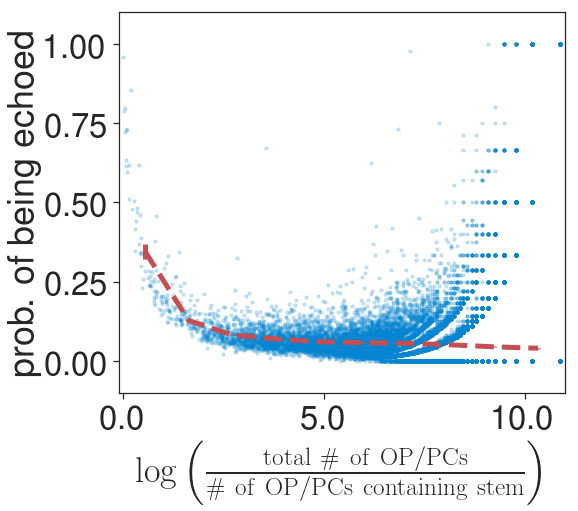

In [5]:
source = [[inst['op_selftext'], inst['deltaed_comment']] for inst in train_data]
target = [inst['explanation'] for inst in train_data]
xp_points = echo_pairs(source, target)
x, y = zip(*xp_points)

fig = scatter_plot(x, y, 
                   xlim=(-0.1, 11), ylim=(-0.1,1.1), 
                   markersize=10,
                   xlabel=r"$\log\left(\frac{\mathrm{total\ \#\ of\ OP/PCs}}{\mathrm{\#\ of\ OP/PCs\ containing\ stem}}\right)$",
                   ylabel="prob. of being echoed")
fig.savefig("../records/plots/copy-oppc_to_exp.png", bbox_inches="tight")